In [1]:
#%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [10]:
for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print( table_name+": ", column.get('name'), " -- ", column.get('type'))

measurement:  id  --  INTEGER
measurement:  station  --  TEXT
measurement:  date  --  TEXT
measurement:  prcp  --  FLOAT
measurement:  tobs  --  FLOAT
station:  id  --  INTEGER
station:  station  --  TEXT
station:  name  --  TEXT
station:  latitude  --  FLOAT
station:  longitude  --  FLOAT
station:  elevation  --  FLOAT


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
today = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#today
#NOTE: The most recent day (what I code as 'today') in this data is 8-23-2017. 

recDate = str(today)[2:-3]
yearAgo = str(eval(recDate[0:4])-1) + recDate[4:]
#yearAgo

# Perform a query to retrieve the data and precipitation scores
yr_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > yearAgo ).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
yr_prcp_df = pd.DataFrame(yr_prcp, columns=['Date', 'Precipitation (in)'])
yr_prcp_df.set_index('Date', inplace=True)
yr_prcp_df.head()



,Precipitation (in)
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


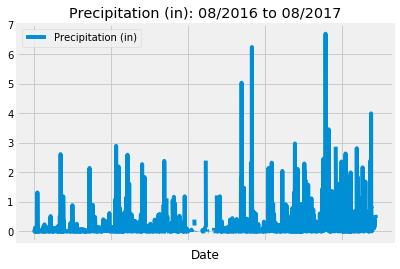

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
yr_prcp_df.plot(use_index=True)
plt.title('Precipitation (in): 08/2016 to 08/2017')

# Rotate the xticks for the dates
plt.xticks(rotation=45)
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
yr_prcp_df.describe()

,Precipitation (in)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
station_list = session.query(Station.station)
station_list.count()

9

In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for row in station_activity:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
q = session.query(Station.id,
                  Station.name,
                  func.min(Measurement.tobs),
                  func.max(Measurement.tobs),
                  func.avg(Measurement.tobs))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.station == "USC00519281")
avg_tmp_rec = "{0:.1f}".format(q[0][4])
print(f"The most active station ID is: {q[0][0]}, and it is located in {q[0][1]}. \n\
The minimum temperature recorded is {q[0][2]}\n\
The maximum temperature recorded is {q[0][3]}\n\
The average temperature recorded is {avg_tmp_rec}")

The most active station ID is: 7, and it is located in WAIHEE 837.5, HI US. 
The minimum temperature recorded is 54.0
The maximum temperature recorded is 85.0
The average temperature recorded is 71.7


In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_twelve = session.query(Measurement.tobs).filter(Measurement.date > yearAgo)\
    .filter(Measurement.station == "USC00519281").order_by(Measurement.tobs).all()
# for row in tobs_twelve:
#     print(row)
tobs_df = pd.DataFrame(tobs_twelve, columns=['temp'])
tobs_df.head()


,temp
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


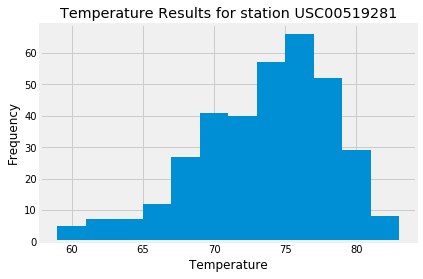

In [18]:
hist = tobs_df.hist(bins=12)
plt.title("Temperature Results for station USC00519281")
plt.xlabel('Temperature')
plt.ylabel("Frequency")
plt.show()

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    results = session.query(Measurement.tobs).filter(Measurement.date >= start_date, Measurement.date <= end_date).all()
    results_ra = np.ravel(results)
    TMIN = np.min(results_ra)
    TAVE = np.average(results_ra)
    TMAX = np.max(results_ra)
    return TMIN, TAVE, TMAX

print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 69.57142857142857, 74.0)


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-02-28', '2017-03-05'))

(64.0, 72.02777777777777, 78.0)


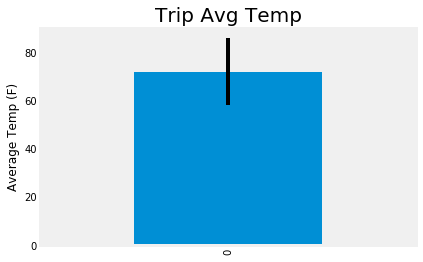

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_results = [calc_temps('2017-02-28', '2017-03-05')]
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
yerr = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=yerr)
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Average Temp (F)")
plt.grid()
plt.show()


In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

vacation_data = session.query(Station.station,
                  func.sum(Measurement.prcp),
                  Station.name,
                  Station.elevation,                                    
                  Station.latitude,
                  Station.longitude)\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= '2017-02-28')\
.filter(Measurement.date <= '2017-03-05')\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc())
for row in vacation_data:
    print(row)


('USC00519281', 4.720000000000001, 'WAIHEE 837.5, HI US', 32.9, 21.45167, -157.84888999999998)
('USC00513117', 4.45, 'KANEOHE 838.1, HI US', 14.6, 21.4234, -157.8015)
('USC00516128', 4.07, 'MANOA LYON ARBO 785.2, HI US', 152.4, 21.3331, -157.8025)
('USC00517948', 2.98, 'PEARL CITY, HI US', 11.9, 21.3934, -157.9751)
('USC00519397', 2.7399999999999998, 'WAIKIKI 717.2, HI US', 3.0, 21.2716, -157.8168)
('USC00519523', 2.32, 'WAIMANALO EXPERIMENTAL FARM, HI US', 19.5, 21.33556, -157.71139)
('USC00514830', 1.1600000000000001, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 7.0, 21.5213, -157.8374)


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
